# Airport Routes Network Analysis

**Course:** Social and Economic Data Science Master, University of Konstanz  
**Topic:** Real-World Network Analysis

---

## Overview

In this notebook, we'll analyze a real-world network of airport routes. Each airport is a node, and each flight route is a directed edge. This type of analysis helps us understand:

- **Hub airports**: Which airports are most connected?
- **Network structure**: How well connected is the global aviation network?
- **Geographical patterns**: Do nearby airports tend to connect to each other?
- **Network efficiency**: How many stops does it take to get anywhere?

## Learning Objectives

By the end of this session, you will be able to:
- Build a directed network from real-world data
- Analyze network connectivity (weak vs strong components)
- Compute and interpret key network metrics
- Visualize networks geographically
- Analyze degree distributions and assortativity

---

## Part 1: Data Import and Network Construction

In [3]:
# Import necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

# Set plotting style
plt.style.use('default')
%matplotlib inline

### 1.1 Loading the Data

We have two datasets:
- `airports.csv`: Information about each airport (ID, name, location, etc.)
- `routes.csv`: Flight routes between airports (source → destination)

In [4]:
# Define column names for the datasets
airport_columns = ["Airport ID", "Name", "City", "Country", "IATA", "ICAO",
                   "Latitude", "Longitude", "Altitude", "Timezone",
                   "DST", "TZ Database Timezone", "Type", "Source"]

route_columns = ["Airline", "Airline ID", "Source Airport", "Source Airport ID",
                 "Destination Airport", "Destination Airport ID", "Codeshare",
                 "Stops", "Equipment"]

# Load datasets without headers
airports_df = pd.read_csv("airports.csv", names=airport_columns, encoding="utf-8")
routes_df = pd.read_csv("routes.csv", names=route_columns, encoding="utf-8")

# Convert IDs to strings for consistency
airports_df['Airport ID'] = airports_df['Airport ID'].astype(str)
routes_df['Source Airport ID'] = routes_df['Source Airport ID'].astype(str)
routes_df['Destination Airport ID'] = routes_df['Destination Airport ID'].astype(str)

print(f"Loaded {len(airports_df)} airports and {len(routes_df)} routes")

Loaded 7698 airports and 67663 routes


In [5]:
# Let's look at a sample of the data
print("\nSample airports:")
print(airports_df.head())

print("\nSample routes:")
print(routes_df.head())


Sample airports:
  Airport ID                                         Name          City  \
0          1                               Goroka Airport        Goroka   
1          2                               Madang Airport        Madang   
2          3                 Mount Hagen Kagamuga Airport   Mount Hagen   
3          4                               Nadzab Airport        Nadzab   
4          5  Port Moresby Jacksons International Airport  Port Moresby   

            Country IATA  ICAO  Latitude   Longitude  Altitude Timezone DST  \
0  Papua New Guinea  GKA  AYGA -6.081690  145.391998      5282       10   U   
1  Papua New Guinea  MAG  AYMD -5.207080  145.789001        20       10   U   
2  Papua New Guinea  HGU  AYMH -5.826790  144.296005      5388       10   U   
3  Papua New Guinea  LAE  AYNZ -6.569803  146.725977       239       10   U   
4  Papua New Guinea  POM  AYPY -9.443380  147.220001       146       10   U   

   TZ Database Timezone     Type       Source  
0  Pacif

### 1.2 Building the Network

We'll create a directed graph where:
- **Nodes** = airports
- **Edges** = flight routes (directed from source to destination)
- **Node attributes** = airport name, coordinates, etc.

In [6]:
# Create a dictionary for airport data with Airport ID as the key
# We filter to only include actual airports (not train stations, etc.)
airport_map = {
    row['Airport ID']: (row['Name'], row['IATA'], row['Latitude'], row['Longitude'])
    for _, row in airports_df.iterrows() if row['Type'] == 'airport'
}

print(f"Total airports of type 'airport': {len(airport_map)}")

Total airports of type 'airport': 7698


In [7]:
# Filter routes to only include those with valid airports at both ends
routes_df_filtered = routes_df[
    routes_df['Source Airport ID'].isin(airport_map.keys()) &
    routes_df['Destination Airport ID'].isin(airport_map.keys())
]

print(f"Valid routes: {len(routes_df_filtered)} (filtered from {len(routes_df)})")

Valid routes: 66771 (filtered from 67663)


In [8]:
# Create the directed graph
G = nx.DiGraph()

# Add nodes with airport information
for airport_id, (name, code, lat, lon) in airport_map.items():
    G.add_node(airport_id, name=name, code=code, latitude=lat, longitude=lon)

# Add edges for valid routes
for _, row in routes_df_filtered.iterrows():
    source_id = row['Source Airport ID']
    destination_id = row['Destination Airport ID']
    G.add_edge(source_id, destination_id)

print(f"\nInitial network:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")


Initial network:
  Nodes: 7698
  Edges: 36907


In [9]:
# Remove isolated nodes (airports with no routes)
isolated_nodes = [node for node, degree in dict(G.degree()).items() if degree == 0]
G.remove_nodes_from(isolated_nodes)

print(f"Removed {len(isolated_nodes)} isolated airports")
print(f"\nFinal network:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")

Removed 4484 isolated airports

Final network:
  Nodes: 3214
  Edges: 36907


---

## Part 2: Network Visualization

We'll create two types of visualizations:
1. **Geographic layout**: Airports positioned by their actual coordinates
2. **Force-directed layout**: Airports positioned by their connectivity

### 2.1 Filtering for Visualization

The full network is too dense to visualize effectively. We'll focus on the top 200 most connected airports.

In [42]:
# Calculate degree for all nodes
degree_dict = dict(G.degree())

# Get top 200 nodes by degree
top_200_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:200]
print(top_200_nodes)

# Create subgraph
G_sub = G.subgraph(top_200_nodes).copy()

print(f"Subgraph statistics:")
print(f"  Nodes: {G_sub.number_of_nodes()}")
print(f"  Edges: {G_sub.number_of_edges()}")
print(f"  Density: {nx.density(G_sub):.4f}")

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '15', '16', '18', '21', '24', '27', '28', '29', '30', '31', '32', '33', '34', '36', '37', '40', '41', '45', '48', '49', '50', '54', '55', '56', '58', '60', '61', '62', '63', '65', '67', '68', '69', '70', '71', '72', '73', '75', '77', '78', '79', '80', '85', '87', '90', '91', '94', '99', '100', '105', '106', '108', '109', '111', '112', '113', '115', '116', '117', '119', '120', '121', '122', '125', '126', '127', '128', '132', '133', '135', '136', '139', '140', '141', '143', '144', '145', '146', '147', '148', '149', '152', '153', '154', '155', '156', '160', '161', '162', '164', '166', '167', '168', '169', '170', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '187', '188', '189', '190', '192', '193', '196', '198', '199', '200', '202', '206', '209', '210', '211', '216', '220', '221', '222', '224', '225', '230', '231', '233', '234', '235', '236', '237', '238', '239', '240', '

In [11]:
# Identify top 10 airports for highlighting
top_10_airports = sorted(degree_dict, key=degree_dict.get, reverse=True)[:10]

print("\nTop 10 Most Connected Airports:")
for i, airport_id in enumerate(top_10_airports, 1):
    name = G.nodes[airport_id]['name']
    code = G.nodes[airport_id]['code']
    degree = degree_dict[airport_id]
    print(f"{i:2d}. {name} ({code}): {degree} connections")


Top 10 Most Connected Airports:
 1. Frankfurt am Main Airport (FRA): 477 connections
 2. Charles de Gaulle International Airport (CDG): 470 connections
 3. Amsterdam Airport Schiphol (AMS): 463 connections
 4. Atatürk International Airport (ISL): 451 connections
 5. Hartsfield Jackson Atlanta International Airport (ATL): 433 connections
 6. Chicago O'Hare International Airport (ORD): 409 connections
 7. Beijing Capital International Airport (PEK): 408 connections
 8. Munich Airport (MUC): 380 connections
 9. Domodedovo International Airport (DME): 375 connections
10. Dallas Fort Worth International Airport (DFW): 372 connections


### 2.2 Geographic Visualization

In [12]:
# Define colors for top 10 airports
top_10_colors = ["#FFD1DC", "#FFB3BA", "#FFDFBA", "#FFFFBA", "#BAFFC9",
                 "#BAE1FF", "#DCC8FF", "#C2FFDB", "#FFDAC8", "#FFC0CB"]

# Assign colors and sizes
node_colors = []
node_sizes = []
for node in G_sub.nodes():
    if node in top_10_airports:
        node_colors.append(top_10_colors[top_10_airports.index(node)])
        node_sizes.append(100)
    else:
        node_colors.append("skyblue")
        node_sizes.append(10)

# Create legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f"{G.nodes[node]['name']} ({G.nodes[node]['code']})",
           markersize=10, markerfacecolor=top_10_colors[idx])
    for idx, node in enumerate(top_10_airports)
]

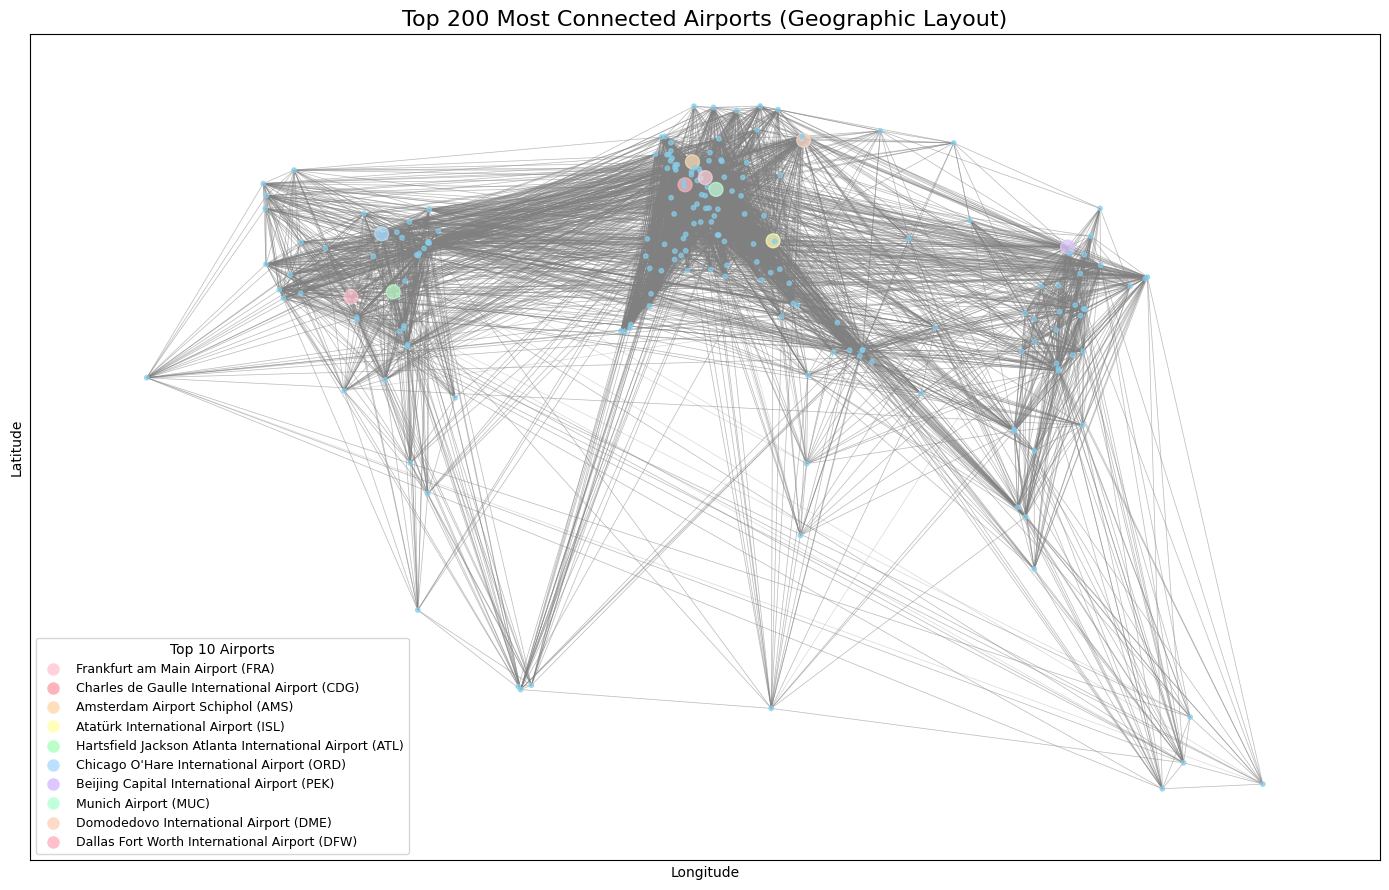

Note: You can see clear continental clusters and major transcontinental routes!


In [13]:
# Create geographic plot
plt.figure(figsize=(14, 9))

# Position nodes by their actual geographic coordinates
pos_geo = {node: (data['longitude'], data['latitude'])
           for node, data in G_sub.nodes(data=True)}

# Draw network
nx.draw_networkx_nodes(G_sub, pos_geo, node_size=node_sizes,
                       node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G_sub, pos_geo, edge_color='gray',
                       alpha=0.3, width=0.5, arrows=False)

# Add legend
plt.legend(handles=legend_elements, loc='lower left',
           title="Top 10 Airports", fontsize=9)
plt.title("Top 200 Most Connected Airports (Geographic Layout)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

print("Note: You can see clear continental clusters and major transcontinental routes!")

### 2.3 Force-Directed Layout

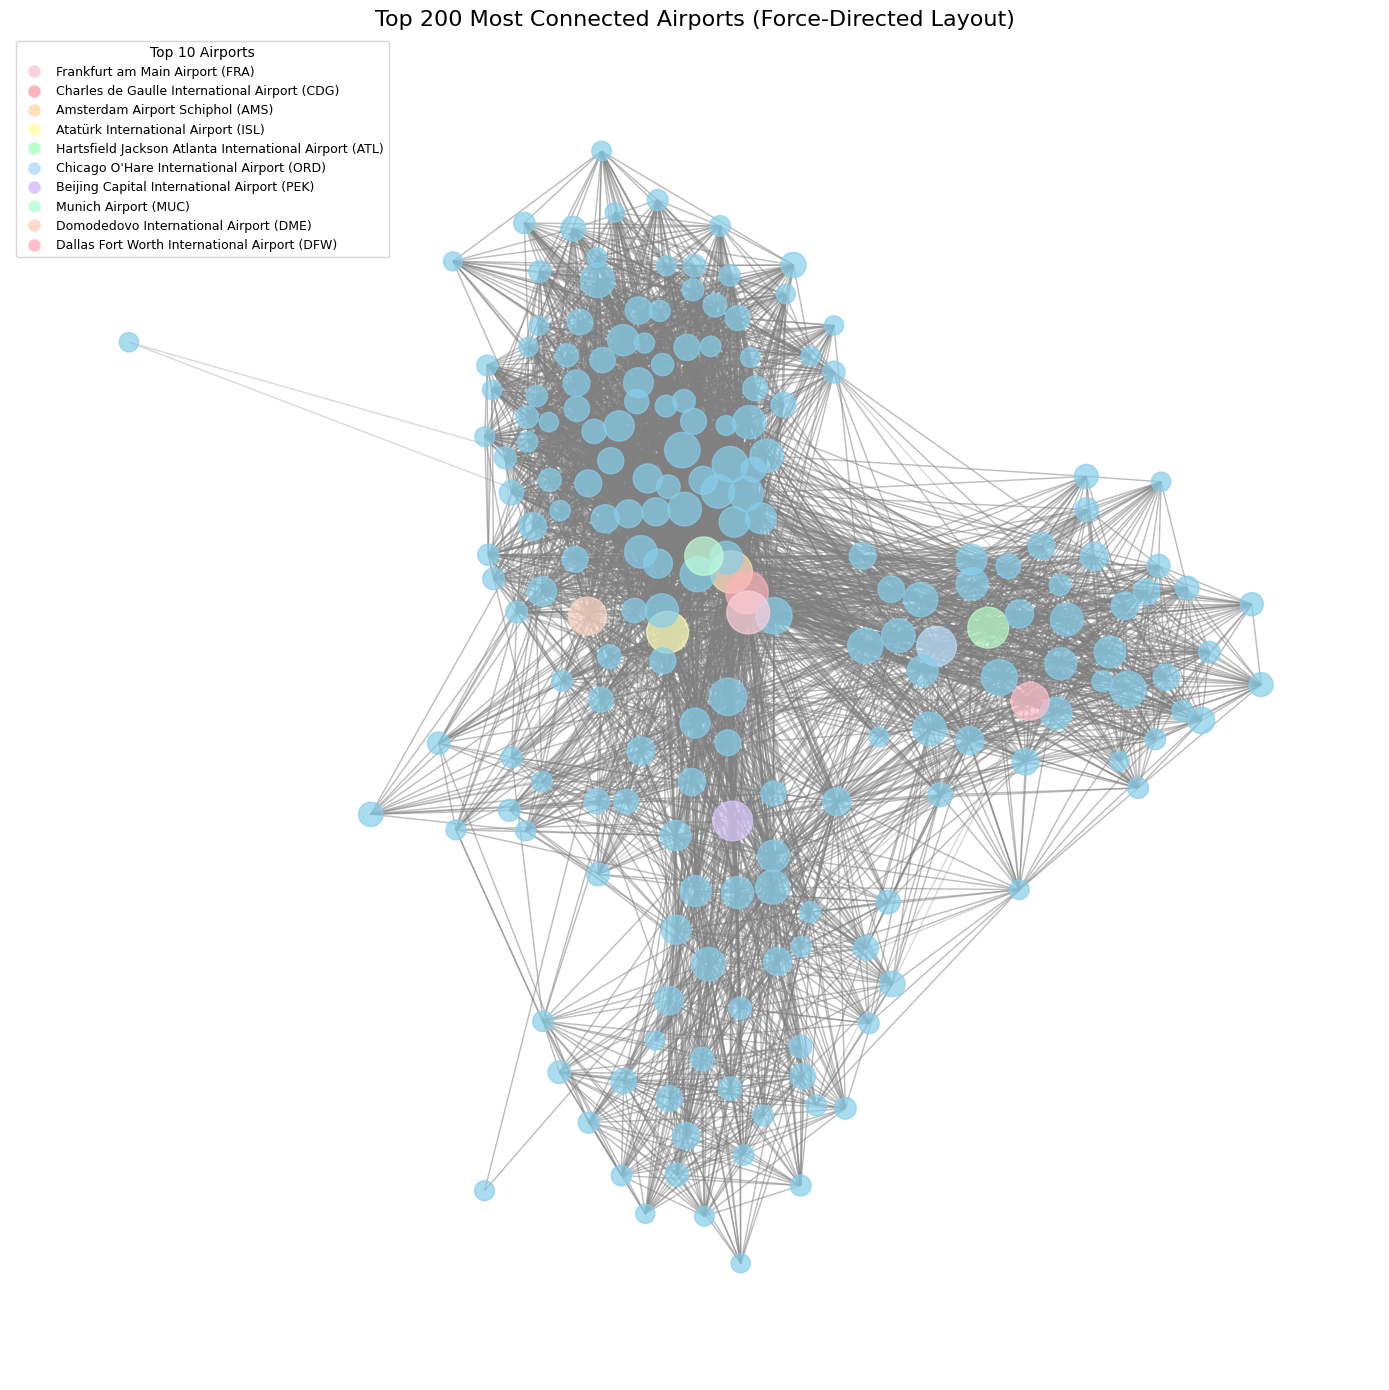

In [14]:
# Create force-directed layout
plt.figure(figsize=(14, 14))
pos_spring = nx.spring_layout(G_sub, seed=42, k=0.5, iterations=50)

# Node sizes proportional to degree
node_sizes_spring = [degree_dict[node] * 2 for node in G_sub.nodes()]

# Draw network
nx.draw_networkx_nodes(G_sub, pos_spring, node_size=node_sizes_spring,
                       node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G_sub, pos_spring, edge_color='gray',
                       alpha=0.3, arrows=False)

# Add legend
plt.legend(handles=legend_elements, loc='upper left',
           title="Top 10 Airports", fontsize=9)
plt.title("Top 200 Most Connected Airports (Force-Directed Layout)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

---

## Part 3: Connectivity Analysis

For directed networks, we can identify two types of connected components:
- **Weakly connected**: Nodes are connected if we ignore edge direction
- **Strongly connected**: Nodes are connected considering edge direction (you can get from any node to any other following directed edges)

### 3.1 Connected Components

In [15]:
# Find weakly connected components
weakly_connected_components = list(nx.weakly_connected_components(G))
largest_weak_component = max(weakly_connected_components, key=len)

print("Weakly Connected Components Analysis:")
print(f"  Number of components: {len(weakly_connected_components)}")
print(f"  Largest component size: {len(largest_weak_component)} nodes")
print(f"  Relative size: {len(largest_weak_component)/G.number_of_nodes():.2%}")

if len(weakly_connected_components) > 1:
    print("\n  Other component sizes:")
    other_sizes = sorted([len(c) for c in weakly_connected_components if len(c) < len(largest_weak_component)], reverse=True)[:5]
    print(f"    {other_sizes}")

Weakly Connected Components Analysis:
  Number of components: 7
  Largest component size: 3188 nodes
  Relative size: 99.19%

  Other component sizes:
    [10, 4, 4, 4, 2]


In [16]:
# Find strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(G))
largest_strong_component = max(strongly_connected_components, key=len)

print("Strongly Connected Components Analysis:")
print(f"  Number of components: {len(strongly_connected_components)}")
print(f"  Largest component size: {len(largest_strong_component)} nodes")
print(f"  Relative size: {len(largest_strong_component)/G.number_of_nodes():.2%}")

if len(strongly_connected_components) > 1:
    print("\n  Other component sizes:")
    other_sizes = sorted([len(c) for c in strongly_connected_components if len(c) < len(largest_strong_component)], reverse=True)[:10]
    print(f"    {other_sizes}")

Strongly Connected Components Analysis:
  Number of components: 48
  Largest component size: 3147 nodes
  Relative size: 97.92%

  Other component sizes:
    [10, 4, 4, 4, 2, 2, 1, 1, 1, 1]


**Interpretation**: The strongly connected component tells us which airports you can reach from each other following actual flight routes. The difference between weak and strong components reveals asymmetries in the network.

In [17]:
# For further analysis, we'll focus on the largest strongly connected component
G_main = G.subgraph(largest_strong_component).copy()

print(f"\nWorking with largest strongly connected component:")
print(f"  Nodes: {G_main.number_of_nodes()}")
print(f"  Edges: {G_main.number_of_edges()}")


Working with largest strongly connected component:
  Nodes: 3147
  Edges: 36816


### 3.2 Basic Network Properties

In [18]:
# Density
density = nx.density(G_main)
print(f"Network Density: {density:.6f}")
print(f"  (Out of {G_main.number_of_nodes() * (G_main.number_of_nodes()-1)} possible edges, "
      f"{G_main.number_of_edges()} exist)")

# Reciprocity (proportion of edges that are bidirectional)
reciprocity = nx.reciprocity(G_main)
print(f"\nReciprocity: {reciprocity:.4f}")
print(f"  {reciprocity:.1%} of routes have a return route")

Network Density: 0.003719
  (Out of 9900462 possible edges, 36816 exist)

Reciprocity: 0.9793
  97.9% of routes have a return route


---

## Part 4: Path Analysis

How many stops does it take to get from one airport to another?

In [19]:
# Calculate all shortest path lengths
print("Computing shortest paths... (this may take a minute)")
path_lengths = dict(nx.shortest_path_length(G_main))
all_lengths = [length for target_dict in path_lengths.values()
               for length in target_dict.values()]

print("Done!")

Computing shortest paths... (this may take a minute)
Done!


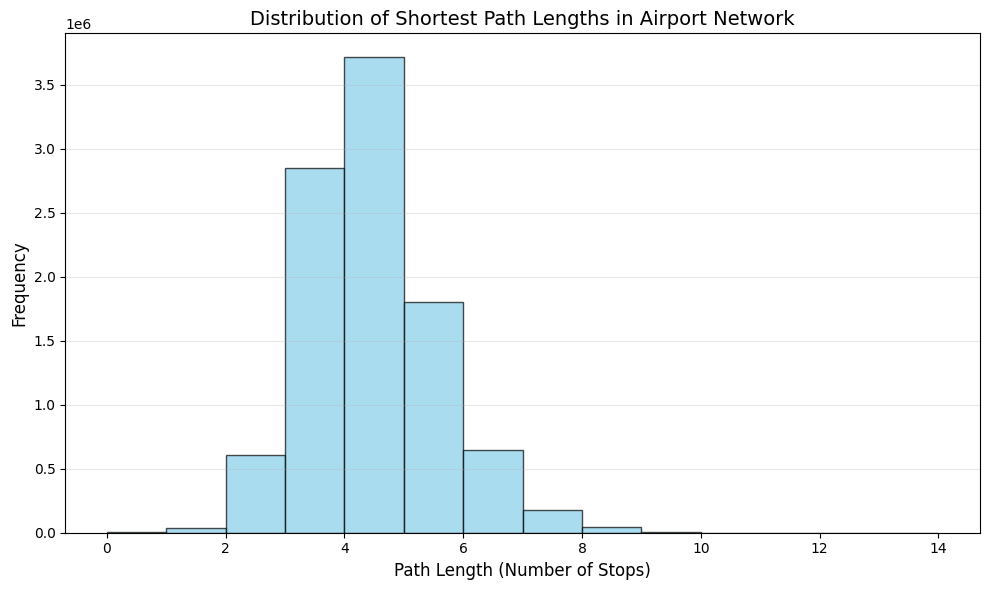


Path Length Statistics:
  Average path length: 3.97 stops
  Diameter (longest shortest path): 13 stops
  Median path length: 4.0 stops


In [20]:
# Plot distribution of path lengths
plt.figure(figsize=(10, 6))
plt.hist(all_lengths, bins=range(min(all_lengths), max(all_lengths)+2),
         edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel("Path Length (Number of Stops)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Shortest Path Lengths in Airport Network", fontsize=14)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Statistics
avg_path_length = nx.average_shortest_path_length(G_main)
diameter = nx.diameter(G_main)

print(f"\nPath Length Statistics:")
print(f"  Average path length: {avg_path_length:.2f} stops")
print(f"  Diameter (longest shortest path): {diameter} stops")
print(f"  Median path length: {np.median(all_lengths):.1f} stops")

**Interpretation**: This tells us how efficient the airline network is. A low average path length means you can reach most airports with few connections.

---

## Part 5: Degree Analysis

In directed networks, we distinguish between:
- **In-degree**: Number of incoming flights (how many airports fly TO this one)
- **Out-degree**: Number of outgoing flights (how many airports this one flies TO)

### 5.1 Top Hub Airports

In [21]:
# Top hubs by in-degree
top_in_hubs = sorted(G_main.in_degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Airports by IN-DEGREE (most arrival routes):")
print("="*70)
for i, (node, degree) in enumerate(top_in_hubs, 1):
    name = G_main.nodes[node]["name"]
    code = G_main.nodes[node].get("code", "N/A")
    print(f"{i:2d}. {name:40s} ({code:3s}): {degree:4d} incoming routes")

Top 10 Airports by IN-DEGREE (most arrival routes):
 1. Frankfurt am Main Airport                (FRA):  238 incoming routes
 2. Charles de Gaulle International Airport  (CDG):  232 incoming routes
 3. Amsterdam Airport Schiphol               (AMS):  231 incoming routes
 4. Atatürk International Airport            (ISL):  227 incoming routes
 5. Hartsfield Jackson Atlanta International Airport (ATL):  216 incoming routes
 6. Beijing Capital International Airport    (PEK):  204 incoming routes
 7. Chicago O'Hare International Airport     (ORD):  203 incoming routes
 8. Munich Airport                           (MUC):  189 incoming routes
 9. Domodedovo International Airport         (DME):  188 incoming routes
10. Dallas Fort Worth International Airport  (DFW):  185 incoming routes


In [22]:
# Top hubs by out-degree
top_out_hubs = sorted(G_main.out_degree(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Airports by OUT-DEGREE (most departure routes):")
print("="*70)
for i, (node, degree) in enumerate(top_out_hubs, 1):
    name = G_main.nodes[node]["name"]
    code = G_main.nodes[node].get("code", "N/A")
    print(f"{i:2d}. {name:40s} ({code:3s}): {degree:4d} outgoing routes")

Top 10 Airports by OUT-DEGREE (most departure routes):
 1. Frankfurt am Main Airport                (FRA):  239 outgoing routes
 2. Charles de Gaulle International Airport  (CDG):  237 outgoing routes
 3. Amsterdam Airport Schiphol               (AMS):  232 outgoing routes
 4. Atatürk International Airport            (ISL):  224 outgoing routes
 5. Hartsfield Jackson Atlanta International Airport (ATL):  217 outgoing routes
 6. Chicago O'Hare International Airport     (ORD):  205 outgoing routes
 7. Beijing Capital International Airport    (PEK):  204 outgoing routes
 8. Munich Airport                           (MUC):  191 outgoing routes
 9. Domodedovo International Airport         (DME):  187 outgoing routes
10. Dallas Fort Worth International Airport  (DFW):  186 outgoing routes


### 5.2 Degree Distribution

In [23]:
# Calculate degree sequences
in_degree_sequence = [in_degree for node, in_degree in G_main.in_degree()]
out_degree_sequence = [out_degree for node, out_degree in G_main.out_degree()]

# Calculate probability distributions
in_degree_counts = np.bincount(in_degree_sequence)
in_degree_prob = in_degree_counts / sum(in_degree_counts)

out_degree_counts = np.bincount(out_degree_sequence)
out_degree_prob = out_degree_counts / sum(out_degree_counts)

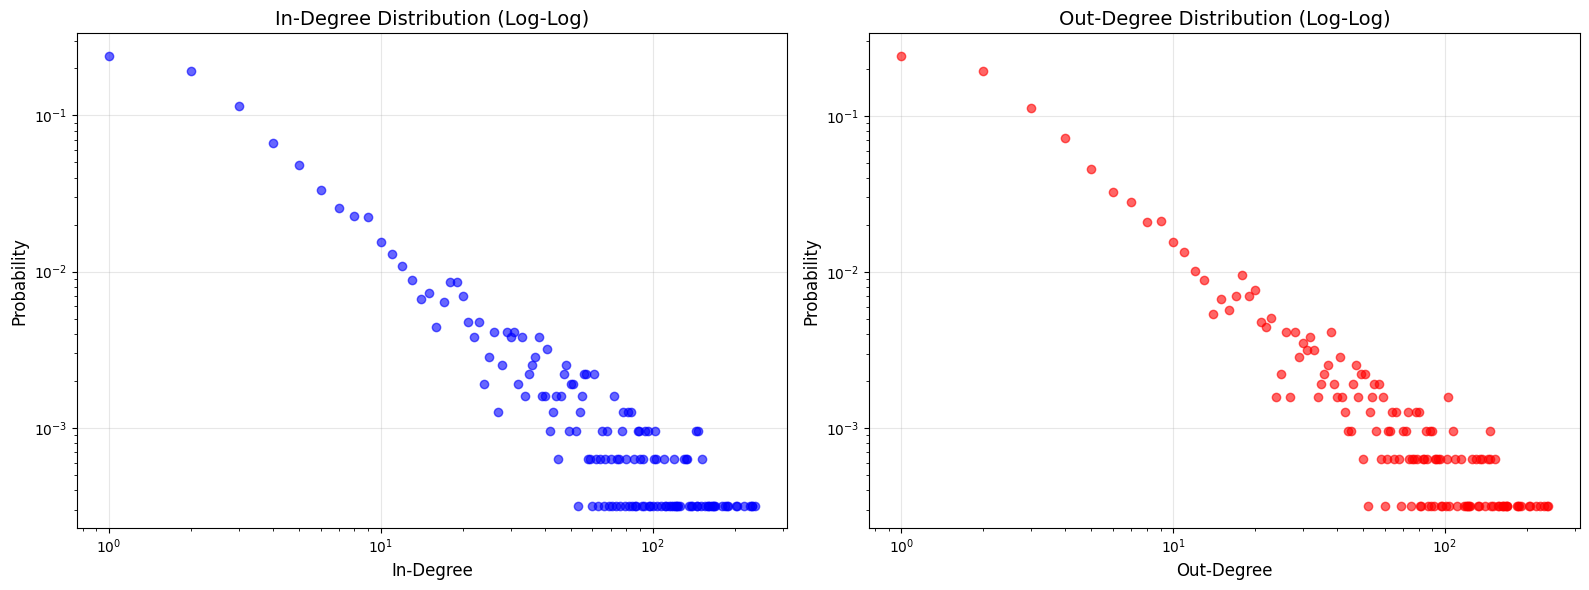

Note: The log-log plot helps us see if the network follows a power-law distribution.
A straight line would indicate a scale-free network (many small airports, few large hubs).


In [24]:
# Plot both degree distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# In-degree distribution
axes[0].plot(range(len(in_degree_prob)), in_degree_prob,
             marker="o", linestyle="None", alpha=0.6, color='blue')
axes[0].set_xlabel("In-Degree", fontsize=12)
axes[0].set_ylabel("Probability", fontsize=12)
axes[0].set_title("In-Degree Distribution (Log-Log)", fontsize=14)
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].grid(alpha=0.3)

# Out-degree distribution
axes[1].plot(range(len(out_degree_prob)), out_degree_prob,
             marker="o", linestyle="None", alpha=0.6, color='red')
axes[1].set_xlabel("Out-Degree", fontsize=12)
axes[1].set_ylabel("Probability", fontsize=12)
axes[1].set_title("Out-Degree Distribution (Log-Log)", fontsize=14)
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: The log-log plot helps us see if the network follows a power-law distribution.")
print("A straight line would indicate a scale-free network (many small airports, few large hubs).")

---

## Part 6: Clustering and Assortativity

### 6.1 Global Clustering Coefficient

In [25]:
# Calculate global clustering coefficient (transitivity)
global_clustering = nx.transitivity(G_main)

print(f"Global Clustering Coefficient: {global_clustering:.4f}")
print(f"\nInterpretation: {global_clustering:.2%} of all possible triangles exist in the network.")
print("This measures how likely it is that if A→B and B→C, then A→C also exists.")

Global Clustering Coefficient: 0.2502

Interpretation: 25.02% of all possible triangles exist in the network.
This measures how likely it is that if A→B and B→C, then A→C also exists.


### 6.2 Degree Assortativity

Do highly connected airports tend to connect to other highly connected airports?

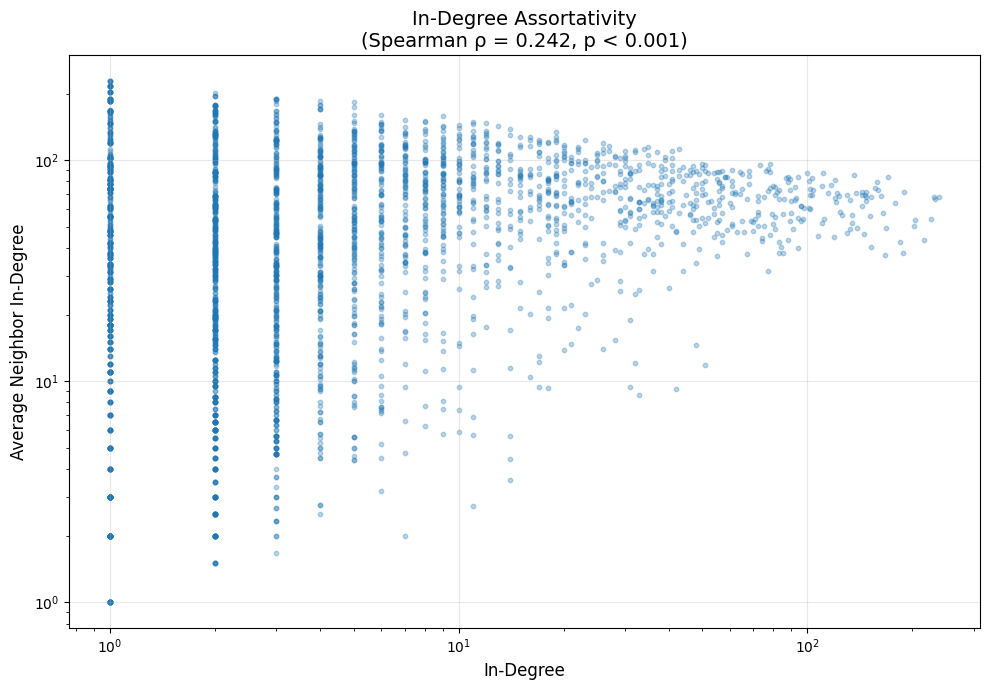


Positive assortativity: Major hubs tend to connect to other major hubs.


In [26]:
# Calculate average neighbor in-degree for each node
average_neighbor_in_degree = nx.average_neighbor_degree(G_main, source="in", target="in")
node_in_degrees = dict(G_main.in_degree())

# Prepare data for plotting
x_in_degrees = [node_in_degrees[node] for node in G_main.nodes()]
y_avg_neighbor_in_degrees = [average_neighbor_in_degree[node] for node in G_main.nodes()]

# Calculate correlation
spearman_corr, p_value = spearmanr(x_in_degrees, y_avg_neighbor_in_degrees)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(x_in_degrees, y_avg_neighbor_in_degrees, alpha=0.3, s=10)
plt.xlabel("In-Degree", fontsize=12)
plt.ylabel("Average Neighbor In-Degree", fontsize=12)
plt.title(f"In-Degree Assortativity\n(Spearman ρ = {spearman_corr:.3f}, p < 0.001)", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

if spearman_corr > 0.1:
    print("\nPositive assortativity: Major hubs tend to connect to other major hubs.")
elif spearman_corr < -0.1:
    print("\nNegative assortativity: Major hubs tend to connect to smaller airports.")
else:
    print("\nNo clear assortativity pattern.")

### 6.3 Geographic Assortativity

Do airports tend to connect to other airports at similar latitudes/longitudes?

In [27]:
# Calculate average latitude of neighbor airports
average_neighbor_latitude = {
    node: np.mean([G_main.nodes[neighbor]["latitude"]
                   for neighbor in G_main.predecessors(node)])
    for node in G_main.nodes() if list(G_main.predecessors(node))
}

# Prepare data
node_latitudes = np.array([G_main.nodes[node]["latitude"] for node in average_neighbor_latitude.keys()])
avg_neighbor_latitudes = np.array(list(average_neighbor_latitude.values()))

# Calculate correlation
spearman_corr_lat, _ = spearmanr(node_latitudes, avg_neighbor_latitudes)

# Bin the data for boxplot visualization
num_bins = 10
latitude_bin_edges = np.linspace(node_latitudes.min(), node_latitudes.max(), num_bins + 1)
latitude_bin_indices = np.digitize(node_latitudes, latitude_bin_edges)
binned_latitude_values = [avg_neighbor_latitudes[latitude_bin_indices == i]
                          for i in range(1, num_bins + 1)]

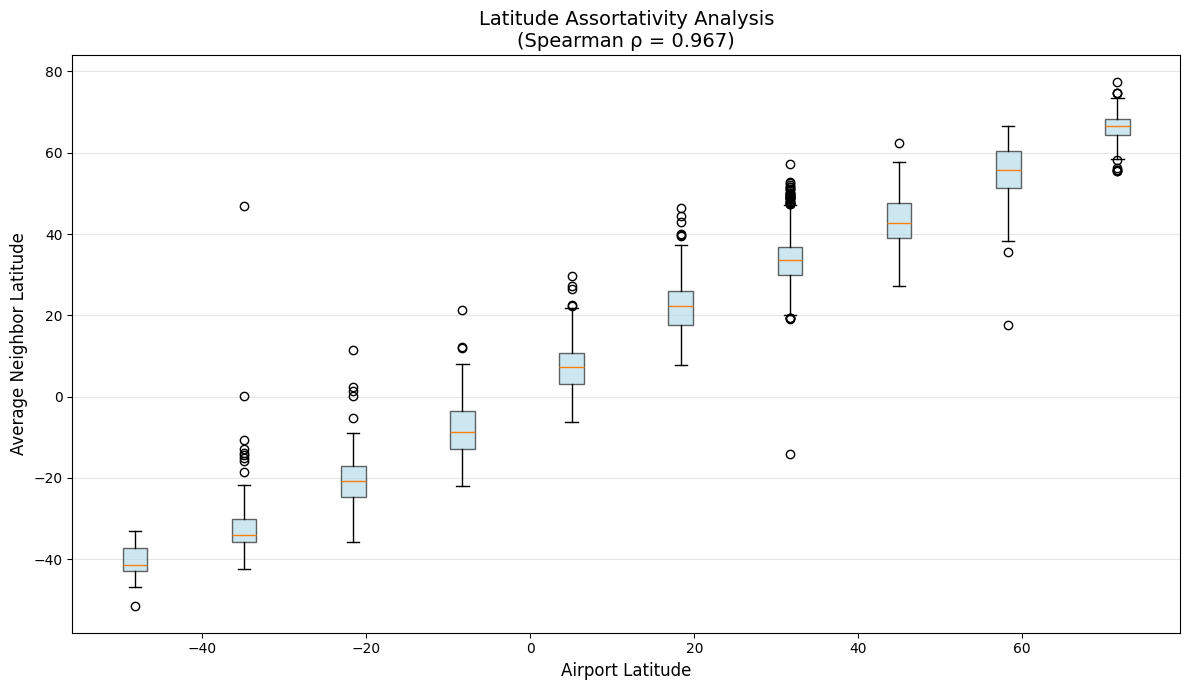


Latitude correlation: 0.967
Strong positive correlation: Airports tend to connect to airports at similar latitudes!


In [28]:
# Plot latitude assortativity
plt.figure(figsize=(12, 7))
plt.boxplot(binned_latitude_values,
            positions=(latitude_bin_edges[:-1] + latitude_bin_edges[1:]) / 2,
            widths=3,
            manage_ticks=False,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', alpha=0.6))

plt.xlabel("Airport Latitude", fontsize=12)
plt.ylabel("Average Neighbor Latitude", fontsize=12)
plt.title(f"Latitude Assortativity Analysis\n(Spearman ρ = {spearman_corr_lat:.3f})", fontsize=14)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nLatitude correlation: {spearman_corr_lat:.3f}")
if spearman_corr_lat > 0.5:
    print("Strong positive correlation: Airports tend to connect to airports at similar latitudes!")
else:
    print("Airports connect across different latitudes.")

---
---

# Student Exercise: City-to-City Flight Network

Now it's your turn! Instead of analyzing individual airports, you'll create and analyze a **city-level network**.

## Why Cities Instead of Airports?

- **More meaningful**: Major cities often have multiple airports (e.g., London has LHR, LGW, STN, LTN, LCY)
- **Simpler interpretation**: City names are more intuitive than airport codes
- **Aggregation practice**: Important skill for network analysis
- **Focus on strong connections**: By keeping only reciprocal routes

## Your Task

Transform the airport network into a city network where:
- **Nodes** = Cities (not individual airports)
- **Edges** = Bidirectional flight connections between cities (undirected network)
- **Logic**: If ANY airport in City A has a reciprocal route with ANY airport in City B, then the cities are connected

**Estimated time: 25-30 minutes**

---

## Part 1: Understanding the Data (5 minutes)

Before building the city network, let's explore the city distribution in our data.

## Part 2: Build the City Network (10-12 minutes)

Now create an undirected network where:
1. Each city is a node
2. Two cities are connected if they have reciprocal flight routes between any of their airports

## Part 3: Analyze the City Network (10-12 minutes)

Now analyze your newly created city network!

## Bonus Challenges

If you finish early, try one of these:

**Challenge 1:** Find the shortest path between two cities of your choice. How many stops?

**Challenge 2:** Create a regional city network (e.g., only European cities) and analyze its properties.

**Challenge 3:** Weighted network - instead of just connections, count HOW MANY reciprocal airport pairs connect each city pair. Create a weighted city network and analyze it.
